# Problem Statement: performing time series sales forecasting with Facebook Prophet and determining whether outliers play a part in forecasting effectiveness.

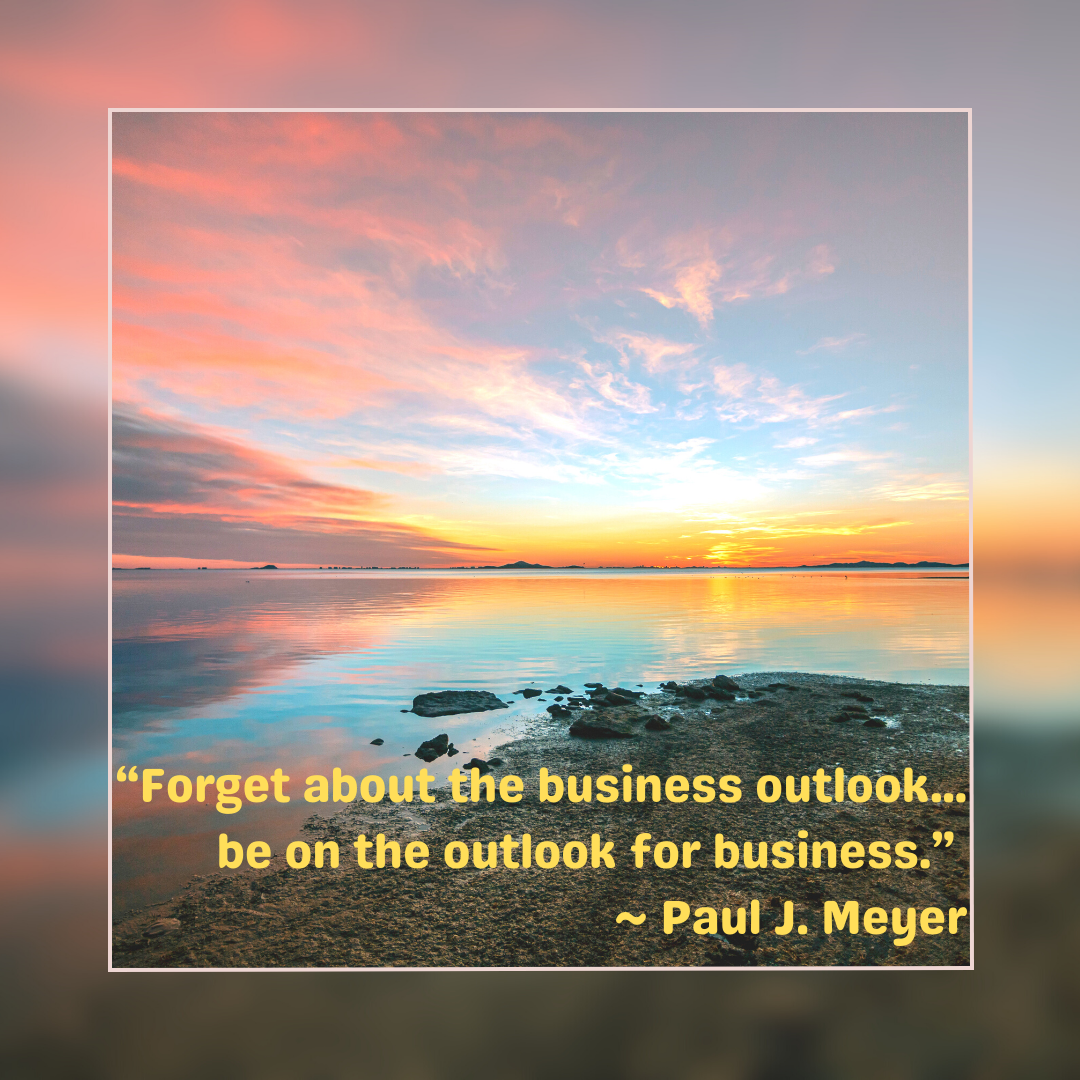

In [ ]:
# import the package
!pip install virtualenv

# create the virtual environment
!virtualenv timeanalysis

# activate the virtual environment
!source timeanalysis/bin/activate

# checking the packages installed in the virtual environment
!pip list


created virtual environment CPython3.10.12.final.0-64 in 295ms
  creator CPython3Posix(dest=/content/timeanalysis, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.2.1, setuptools==68.2.2, wheel==0.41.2
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                  

In [ ]:
# install the fbprophet package (use prophet and not fbprophet as per documentation)
!pip install prophet

In [ ]:
# import relevant packages / modules
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import visualizaton packages / modules
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# setting display options
pd.options.display.min_rows = 50
pd.options.display.max_columns = 20
pd.options.display.precision = 2

sns.set_theme(style='whitegrid', palette='pastel', rc={'figure.dpi':150, 'figure.figsize':(8,6)})

In [ ]:
# read in the dataset
filename = '/content/timeanalysis/Superstore Sales Dataset.csv'
data = pd.read_csv(filename, parse_dates = ['Ship Date', 'Order Date'], dayfirst = True)

In [ ]:
# have an understanding of the dataset - column names, data types, missing values, etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [ ]:
# have a look at the first 5 rows of the dataset
data.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
1       2  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
2       3  CA-2017-138688 2017-06-12 2017-06-16    Second Class    DV-13045   
3       4  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   
4       5  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name   Sales  
0                  Bush Somerset Collection Bookcase  261.96  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94  
2  Self-Adhesive Address Labels for Typewriters b...   14.62  
3      Bretford CR4500 Series Slim Rectangular Table  957.58  
4                     Eldon Fold 'N Roll Cart System   22.37

In [ ]:
# check for missing values (as noted above. there are missing values in Postal Code)
data.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [ ]:
# check for duplicates
data.duplicated().sum()

0

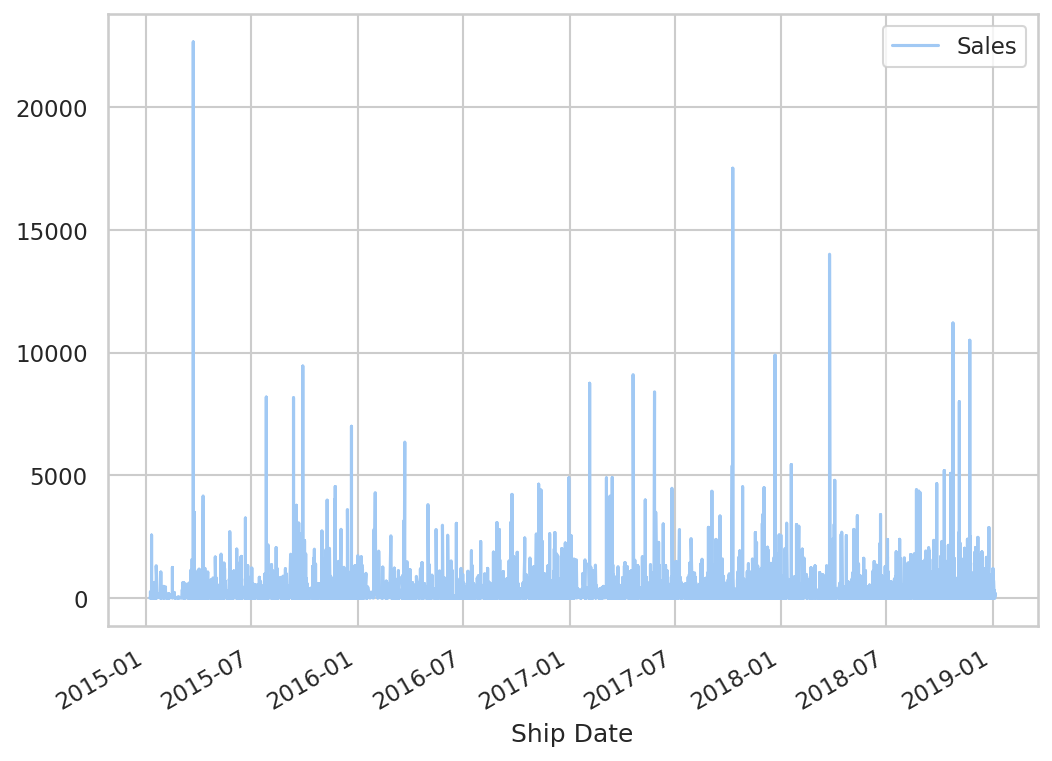

In [ ]:
# plotting sales and time
data.plot(x='Ship Date', y='Sales');

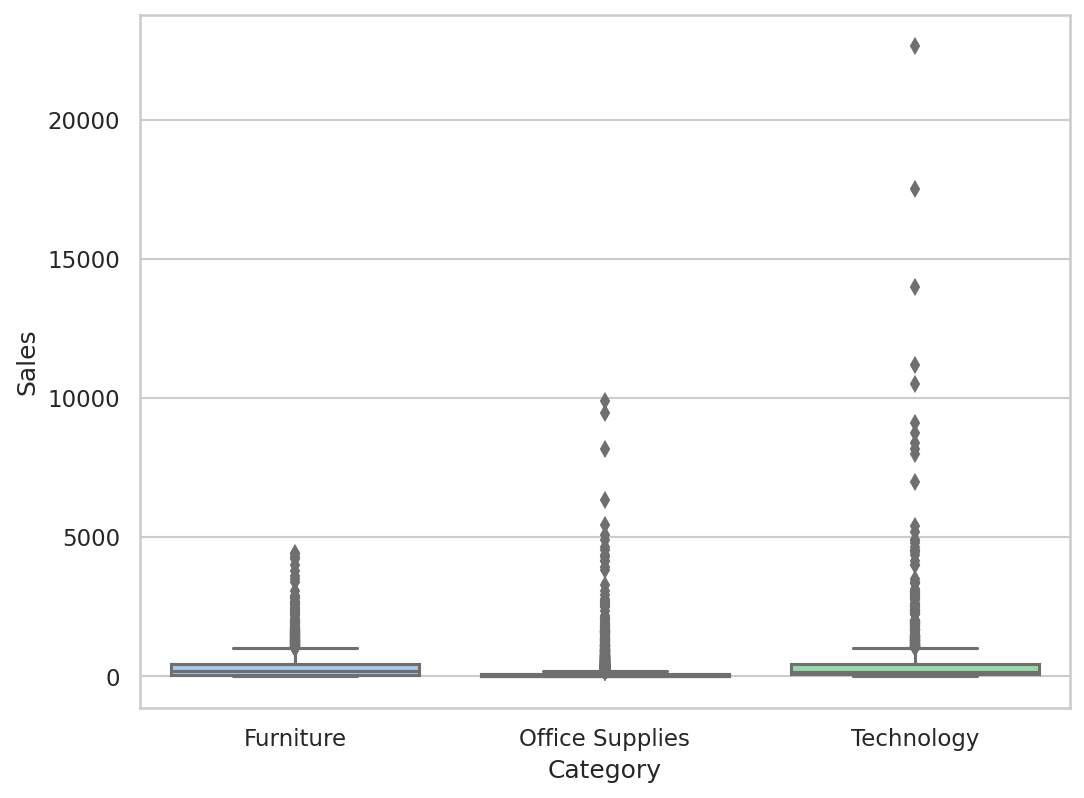

In [ ]:
# plot distribution of sales amongst the 3 categories to understand whether there are any outliers
sns.boxplot(data=data, x='Category', y='Sales' );

In [ ]:
# make a copy of the dataset
df = data[['Ship Date','Category','Sales']]
df.head()


Ship Date         Category   Sales
0 2017-11-11        Furniture  261.96
1 2017-11-11        Furniture  731.94
2 2017-06-16  Office Supplies   14.62
3 2016-10-18        Furniture  957.58
4 2016-10-18  Office Supplies   22.37

In [ ]:
# change dtype to category
df['Category'] = df['Category'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ship Date  9800 non-null   datetime64[ns]
 1   Category   9800 non-null   category      
 2   Sales      9800 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 162.9 KB


In [ ]:
# use numerical values to represent categorical feature
df['Category'] = df['Category'].map({"Furniture":0, "Office Supplies":1,"Technology":2})
df.head()

Ship Date Category   Sales
0 2017-11-11        0  261.96
1 2017-11-11        0  731.94
2 2017-06-16        1   14.62
3 2016-10-18        0  957.58
4 2016-10-18        1   22.37

In [ ]:
# create additional features (i.e. feature engineering)
import datetime as dt
df['day'] = df['Ship Date'].dt.day
df['year'] = df['Ship Date'].dt.year
df['month'] = df['Ship Date'].dt.month
df['weekday'] = df['Ship Date'].dt.weekday
df['week'] = df['Ship Date'].dt.isocalendar().week

In [ ]:
# review 'new' DF
df.head()

Ship Date Category   Sales  day  year  month  weekday  week
0 2017-11-11        0  261.96   11  2017     11        5    45
1 2017-11-11        0  731.94   11  2017     11        5    45
2 2017-06-16        1   14.62   16  2017      6        4    24
3 2016-10-18        0  957.58   18  2016     10        1    42
4 2016-10-18        1   22.37   18  2016     10        1    42

In [ ]:
# determine the average sales for each day of each month which will assist to determine if a sales is an outlier
df_avg = df.groupby(['day','month'])['Sales'].mean()
df_avg.head()

day  month
1    1        149.15
     2        205.82
     3        157.33
     4        305.89
     5        379.22
Name: Sales, dtype: float64

In [ ]:
# create a new DF combing information of the 'engineered' dataset with the average sales DF
df_final = df.join(df_avg, on=['day','month'], rsuffix='_avg')
df_final.head()

Ship Date Category   Sales  day  year  month  weekday  week  Sales_avg
0 2017-11-11        0  261.96   11  2017     11        5    45     225.94
1 2017-11-11        0  731.94   11  2017     11        5    45     225.94
2 2017-06-16        1   14.62   16  2017      6        4    24     125.19
3 2016-10-18        0  957.58   18  2016     10        1    42     398.65
4 2016-10-18        1   22.37   18  2016     10        1    42     398.65

In [ ]:
# replace missing values with 0
df_final.fillna(0, inplace=True)

In [ ]:
# use scikit-learn IsolationForest algorithm to determine outliers
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.005, max_features=5, n_estimators = 200)
model.fit(df_final[['Sales','day','year','month','weekday','week','Sales_avg']])

df_final['outliers'] = pd.Series(model.predict(df_final[['Sales','day','year','month','weekday','week','Sales_avg']])).apply(lambda x: "yes" if (x==-1) else 'no')

In [ ]:
# review the outliers.  This is an iteractive process where inputs will be sought from operations / business people to determine appropriateness.  E.g. the higher sales on 2015-03-23 of 22,638.48 was due to Business Development team signing on a new/existing customer.
df_final.query("outliers=='yes'")

Ship Date Category     Sales  day  year  month  weekday  week  \
515  2018-01-27        2   2999.95   27  2018      1        5     4   
683  2018-11-04        2   7999.98    4  2018     11        6    44   
977  2018-01-10        2   3059.98   10  2018      1        2     2   
1085 2017-03-05        2   4899.93    5  2017      3        6     9   
1126 2015-01-26        0   1067.94   26  2015      1        0     5   
1155 2015-12-21        0   2244.48   21  2015     12        0    52   
1246 2015-12-14        0   3610.85   14  2015     12        0    51   
1433 2015-12-21        0   1819.86   21  2015     12        0    52   
1644 2016-03-20        2   3149.93   20  2016      3        6    11   
2492 2015-11-23        2   4548.81   23  2015     11        0    48   
2505 2015-07-27        1   8187.65   27  2015      7        0    31   
2579 2015-01-31        1    489.92   31  2015      1        5     5   
2623 2018-10-24        2  11199.97   24  2018     10        2    43   
2696 2015-03-23        2    821.30   23  2015      3        0    13   
2697 2015-03-23        2  22638.48   23  2015      3        0    13   
3070 2015-11-22        1   2934.33   22  2015     11        6    47   
3280 2015-04-09        1   4164.05    9  2015      4        3    15   
4098 2015-09-28        1   9449.95   28  2015      9        0    40   
4190 2018-11-22        2  10499.97   22  2018     11        3    47   
4218 2018-04-03        2   4799.98    3  2018      4        1    14   
4277 2017-04-20        2   9099.93   20  2017      4        3    16   
4937 2015-01-18        1   1325.85   18  2015      1        6     3   
5484 2018-02-04        0    419.14    4  2018      2        6     5   
5562 2018-04-02        2   2999.95    2  2018      4        0    14   
6010 2017-01-03        2   2548.56    3  2017      1        1     1   
6014 2017-03-11        2   4158.91   11  2017      3        5    10   
6295 2016-01-01        1   1737.18    1  2016      1        4    53   
6340 2018-10-09        2   5199.96    9  2018     10        1    41   
6520 2018-01-18        1   5443.96   18  2018      1        3     3   
6534 2015-11-22        1   2152.78   22  2015     11        6    47   
6535 2015-11-22        0   4007.84   22  2015     11        6    47   
6620 2018-01-18        1   4164.05   18  2018      1        3     3   
6626 2015-12-21        2   6999.96   21  2015     12        0    52   
6826 2017-10-09        2  17499.95    9  2017     10        0    41   
6917 2015-12-21        0   1403.92   21  2015     12        0    52   
7474 2015-01-10        0   2573.82   10  2015      1        5     2   
7583 2015-03-25        2   3499.93   25  2015      3        2    13   
7632 2019-01-01        0   1207.84    1  2019      1        1     1   
7683 2016-05-01        1   3812.97    1  2016      5        6    17   
7772 2017-12-02        2   4499.98    2  2017     12        5    48   
8153 2018-03-25        2  13999.96   25  2018      3        6    12   
8271 2017-12-31        0   2563.06   31  2017     12        6    52   
8312 2018-01-31        2   2939.93   31  2018      1        2     5   
8488 2017-02-04        2   8749.95    4  2017      2        5     5   
8990 2016-12-30        2   4899.93   30  2016     12        4    52   
9039 2017-12-21        1   9892.74   21  2017     12        3    51   
9412 2016-01-29        0   2803.92   29  2016      1        4     4   
9490 2018-01-07        1   2022.27    7  2018      1        6     1   
9639 2016-01-31        0   4297.64   31  2016      1        6     4   

      Sales_avg outliers  
515      339.54      yes  
683      391.86      yes  
977      487.65      yes  
1085     399.06      yes  
1126     160.74      yes  
1155     596.84      yes  
1246     314.28      yes  
1433     596.84      yes  
1644     578.16      yes  
2492     311.94      yes  
2505     384.99      yes  
2579     503.61      yes  
2623     548.69      yes  
2696    1041.77      yes  
2697    1041.77      yes  
3070     639.23      ye

In [ ]:
# how many sales amounts are considered as outliers by the algorithm?
df_final['outliers'].value_counts()

no     9751
yes      49
Name: outliers, dtype: int64

In [ ]:
# understand the scoring of each point / sales amount
score = model.decision_function(df_final[['Sales','day','year','month','weekday','week','Sales_avg']])

(array([  1.,   0.,   2.,   1.,   1.,   1.,   1.,   3.,   3.,   6.,   7.,
          6.,   5.,  12.,  10.,  20.,  14.,  21.,  33.,  27.,  35.,  73.,
         64.,  84.,  99.,  91., 147., 124., 135., 207., 215., 239., 319.,
        336., 382., 436., 485., 600., 666., 673., 817., 743., 582., 618.,
        444., 338., 346., 188.,  83.,  57.]),
 array([-0.08230849, -0.07647243, -0.07063638, -0.06480033, -0.05896427,
        -0.05312822, -0.04729217, -0.04145611, -0.03562006, -0.02978401,
        -0.02394795, -0.0181119 , -0.01227585, -0.0064398 , -0.00060374,
         0.00523231,  0.01106836,  0.01690442,  0.02274047,  0.02857652,
         0.03441258,  0.04024863,  0.04608468,  0.05192074,  0.05775679,
         0.06359284,  0.0694289 ,  0.07526495,  0.081101  ,  0.08693705,
         0.09277311,  0.09860916,  0.10444521,  0.11028127,  0.11611732,
         0.12195337,  0.12778943,  0.13362548,  0.13946153,  0.14529759,
         0.15113364,  0.15696969,  0.16280575,  0.1686418 ,  0.17447785,
 

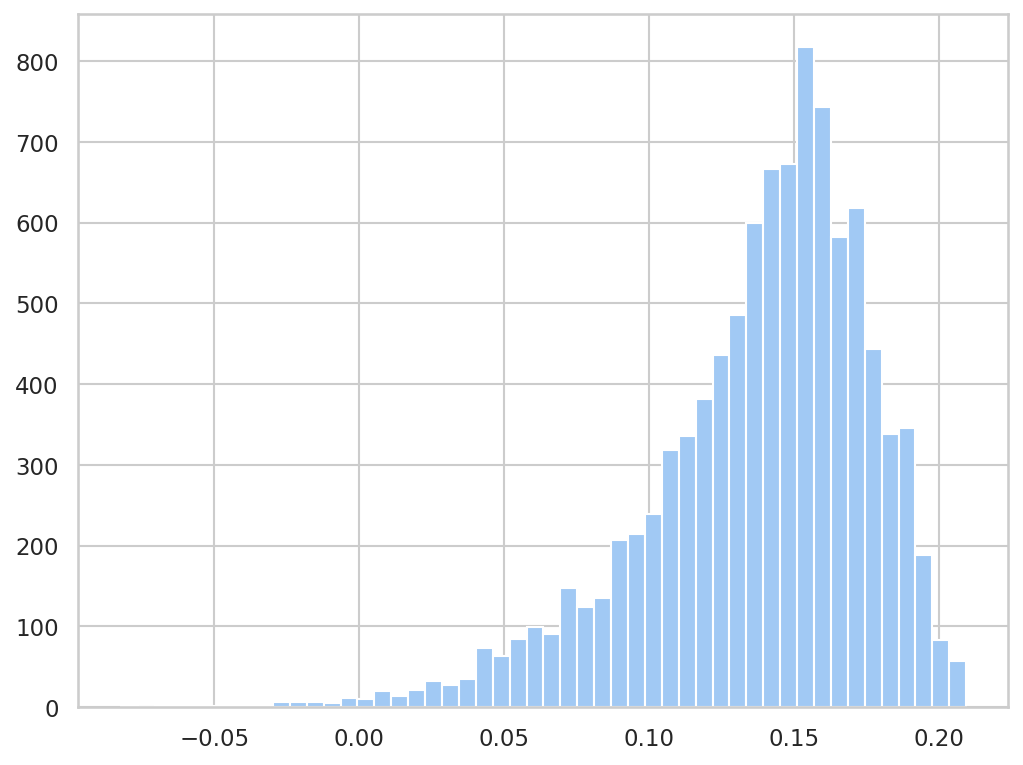

In [ ]:
# plotting the histogram to better understand the distribution
plt.hist(score, bins=50)

In [ ]:
# create a new column in the DF for the score and filter those below a threshold (after input from operational personnel)
df_final['score'] = score
df_final.query("score <-0.03")

Ship Date Category     Sales  day  year  month  weekday  week  \
515  2018-01-27        2   2999.95   27  2018      1        5     4   
1155 2015-12-21        0   2244.48   21  2015     12        0    52   
2697 2015-03-23        2  22638.48   23  2015      3        0    13   
6340 2018-10-09        2   5199.96    9  2018     10        1    41   
6520 2018-01-18        1   5443.96   18  2018      1        3     3   
6620 2018-01-18        1   4164.05   18  2018      1        3     3   
6626 2015-12-21        2   6999.96   21  2015     12        0    52   
6826 2017-10-09        2  17499.95    9  2017     10        0    41   
8153 2018-03-25        2  13999.96   25  2018      3        6    12   
8312 2018-01-31        2   2939.93   31  2018      1        2     5   
8488 2017-02-04        2   8749.95    4  2017      2        5     5   
9039 2017-12-21        1   9892.74   21  2017     12        3    51   
9639 2016-01-31        0   4297.64   31  2016      1        6     4   

      Sales_avg outliers  score  
515      339.54      yes  -0.03  
1155     596.84      yes  -0.03  
2697    1041.77      yes  -0.08  
6340    1066.15      yes  -0.04  
6520     542.47      yes  -0.04  
6620     542.47      yes  -0.04  
6626     596.84      yes  -0.06  
6826    1066.15      yes  -0.05  
8153     683.28      yes  -0.05  
8312     503.61      yes  -0.04  
8488     830.17      yes  -0.07  
9039     596.84      yes  -0.04  
9639     503.61      yes  -0.07

In [ ]:
# create a new DF without those outliers captured with the threshold set by operational personnel and have a look at the 1st 5 rows.
mask = (df_final['score'] > -0.03)
df_normal = df_final[mask]
df_normal.head()

Ship Date Category   Sales  day  year  month  weekday  week  Sales_avg  \
0 2017-11-11        0  261.96   11  2017     11        5    45     225.94   
1 2017-11-11        0  731.94   11  2017     11        5    45     225.94   
2 2017-06-16        1   14.62   16  2017      6        4    24     125.19   
3 2016-10-18        0  957.58   18  2016     10        1    42     398.65   
4 2016-10-18        1   22.37   18  2016     10        1    42     398.65   

  outliers  score  
0       no   0.17  
1       no   0.14  
2       no   0.19  
3       no   0.10  
4       no   0.15

In [ ]:
# understand the df_normal DF
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9787 entries, 0 to 9799
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ship Date  9787 non-null   datetime64[ns]
 1   Category   9787 non-null   category      
 2   Sales      9787 non-null   float64       
 3   day        9787 non-null   int64         
 4   year       9787 non-null   int64         
 5   month      9787 non-null   int64         
 6   weekday    9787 non-null   int64         
 7   week       9787 non-null   UInt32        
 8   Sales_avg  9787 non-null   float64       
 9   outliers   9787 non-null   object        
 10  score      9787 non-null   float64       
dtypes: UInt32(1), category(1), datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 822.1+ KB


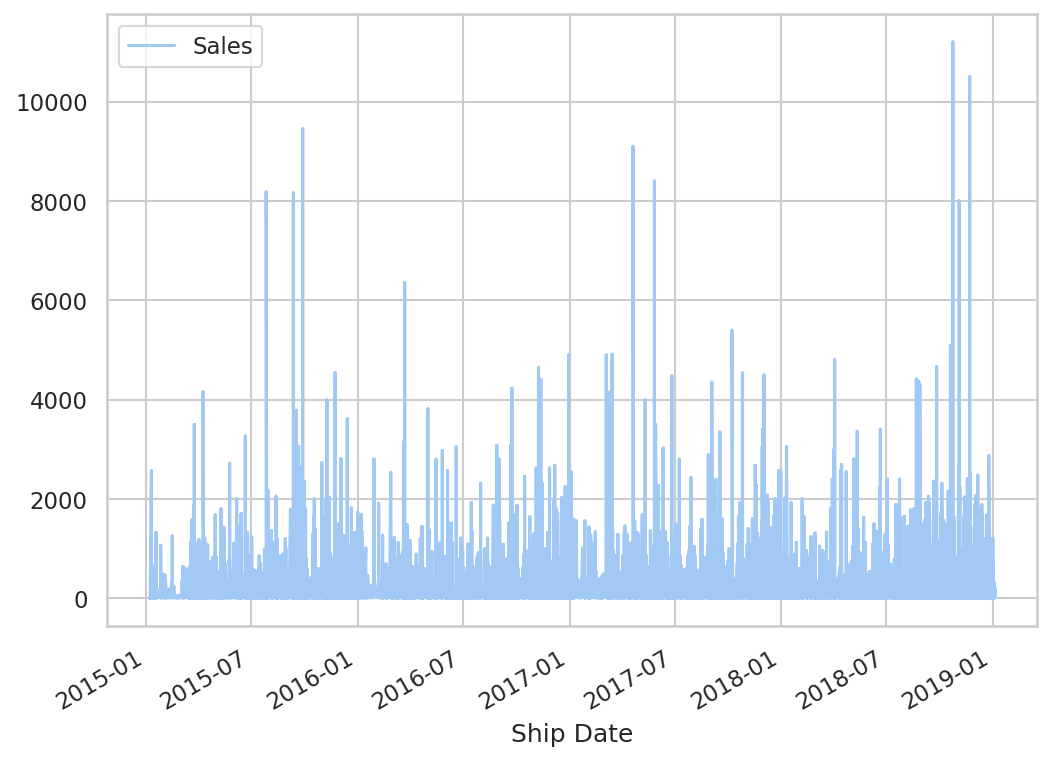

In [ ]:
# plotting the sales and time series
df_normal.plot(x='Ship Date', y='Sales');

In [ ]:
# create a new DF with only the ship date and sales in preparation for doing the forecasting using Prophet
df1 = data[['Ship Date', 'Sales']]

In [ ]:
# review the 1st 5 rows for the DF
df1.head()

Ship Date   Sales
0 2017-11-11  261.96
1 2017-11-11  731.94
2 2017-06-16   14.62
3 2016-10-18  957.58
4 2016-10-18   22.37

In [ ]:
# review the dtypes and info of the DF
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ship Date  9800 non-null   datetime64[ns]
 1   Sales      9800 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.2 KB


In [ ]:
# as noted above, the dates are not unique.  We will resample (similar to groupby) of the Ship Date to daily ('D')
df1 = df1.resample('D', on='Ship Date' ).sum().reset_index()
df1.sample(5)

Ship Date    Sales
1242 2018-06-02  1215.77
763  2017-02-08    88.15
725  2017-01-01   293.07
272  2015-10-06   704.63
1131 2018-02-11   240.78

In [ ]:
# rename columns to ds (datetime object) and y (target) as per FB convention
df1.columns = ['ds','y']
df1.tail()

ds        y
1455 2019-01-01  2390.15
1456 2019-01-02  1545.62
1457 2019-01-03   569.27
1458 2019-01-04   344.22
1459 2019-01-05   310.42

In [ ]:
# setup the model
m = Prophet()

In [ ]:
# train the model
m.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/f5purzda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/jcrya88y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93442', 'data', 'file=/tmp/tmp8phfgpux/f5purzda.json', 'init=/tmp/tmp8phfgpux/jcrya88y.json', 'output', 'file=/tmp/tmp8phfgpux/prophet_modelfsxi8b9t/prophet_model-20231020044402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# create a future DF for the forecast horizon
forecast_horizon = 60
future = m.make_future_dataframe(periods=forecast_horizon, freq='D')


In [ ]:
# make the predictions
forecast = m.predict(future)

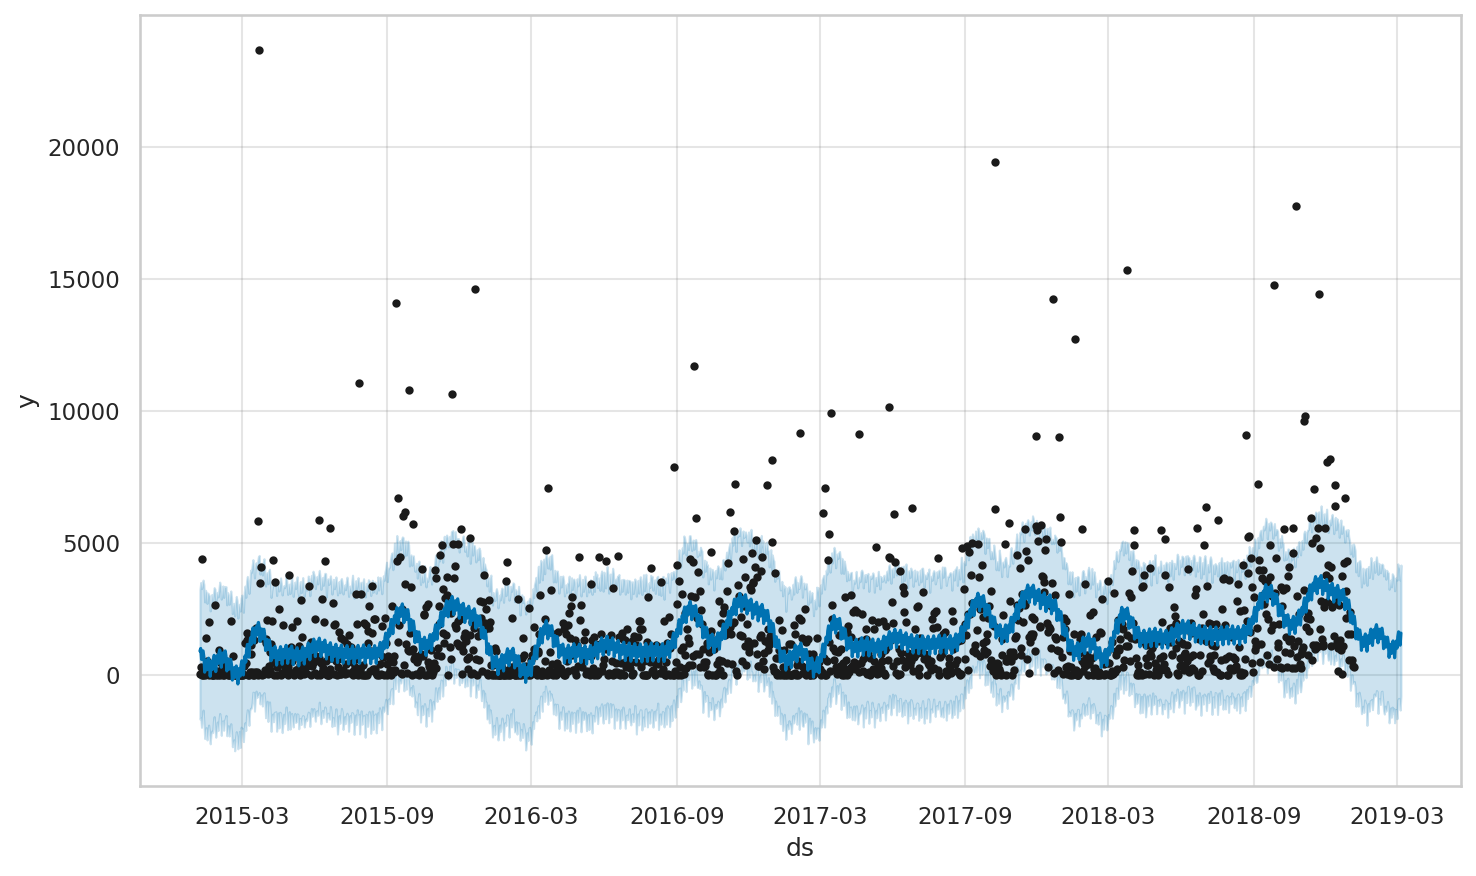

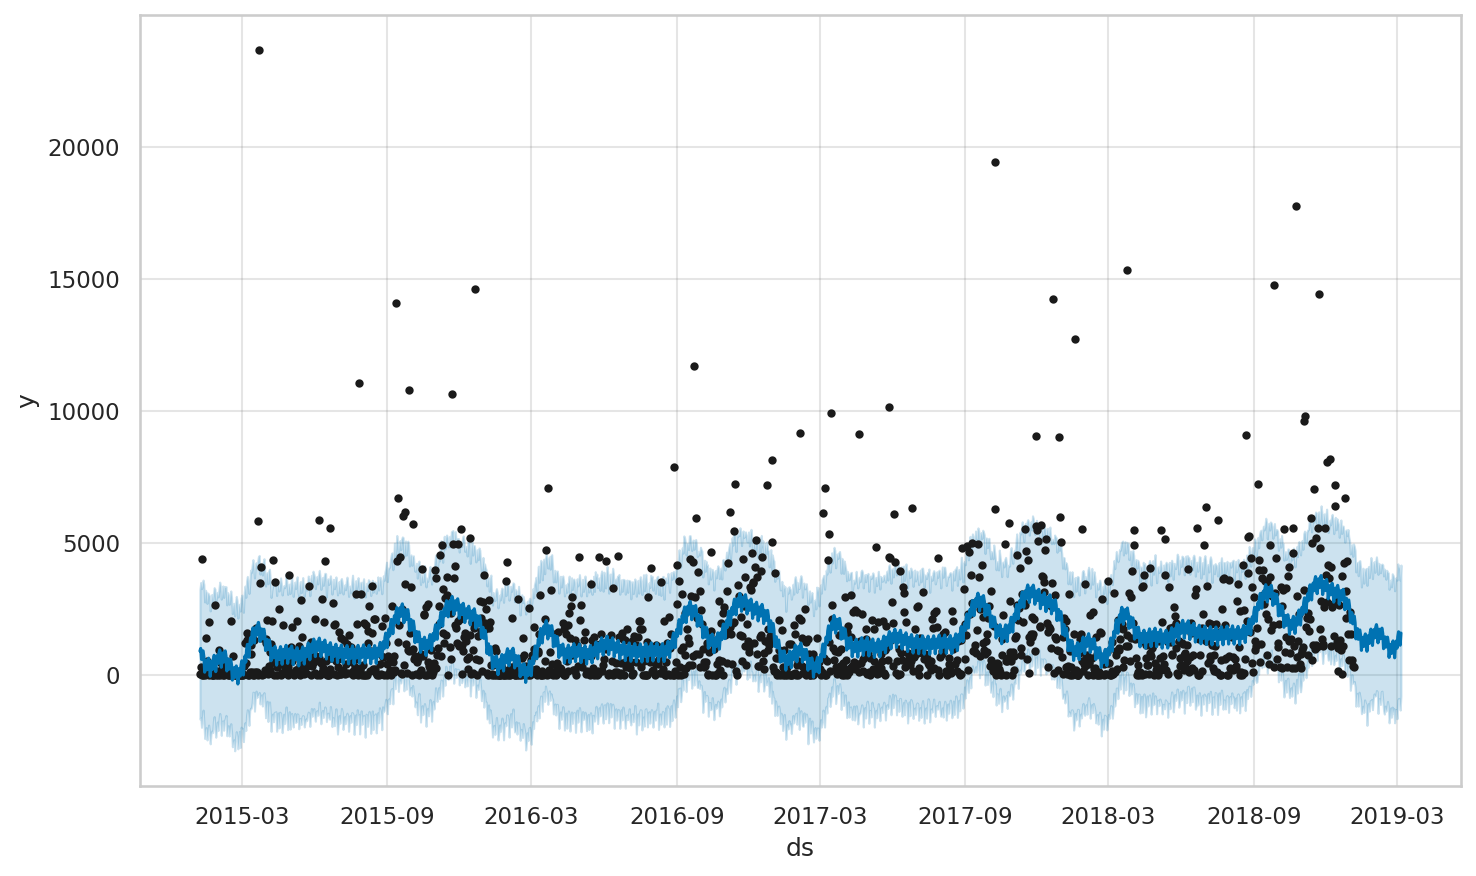

In [ ]:
# plotting the predictions
m.plot(forecast)

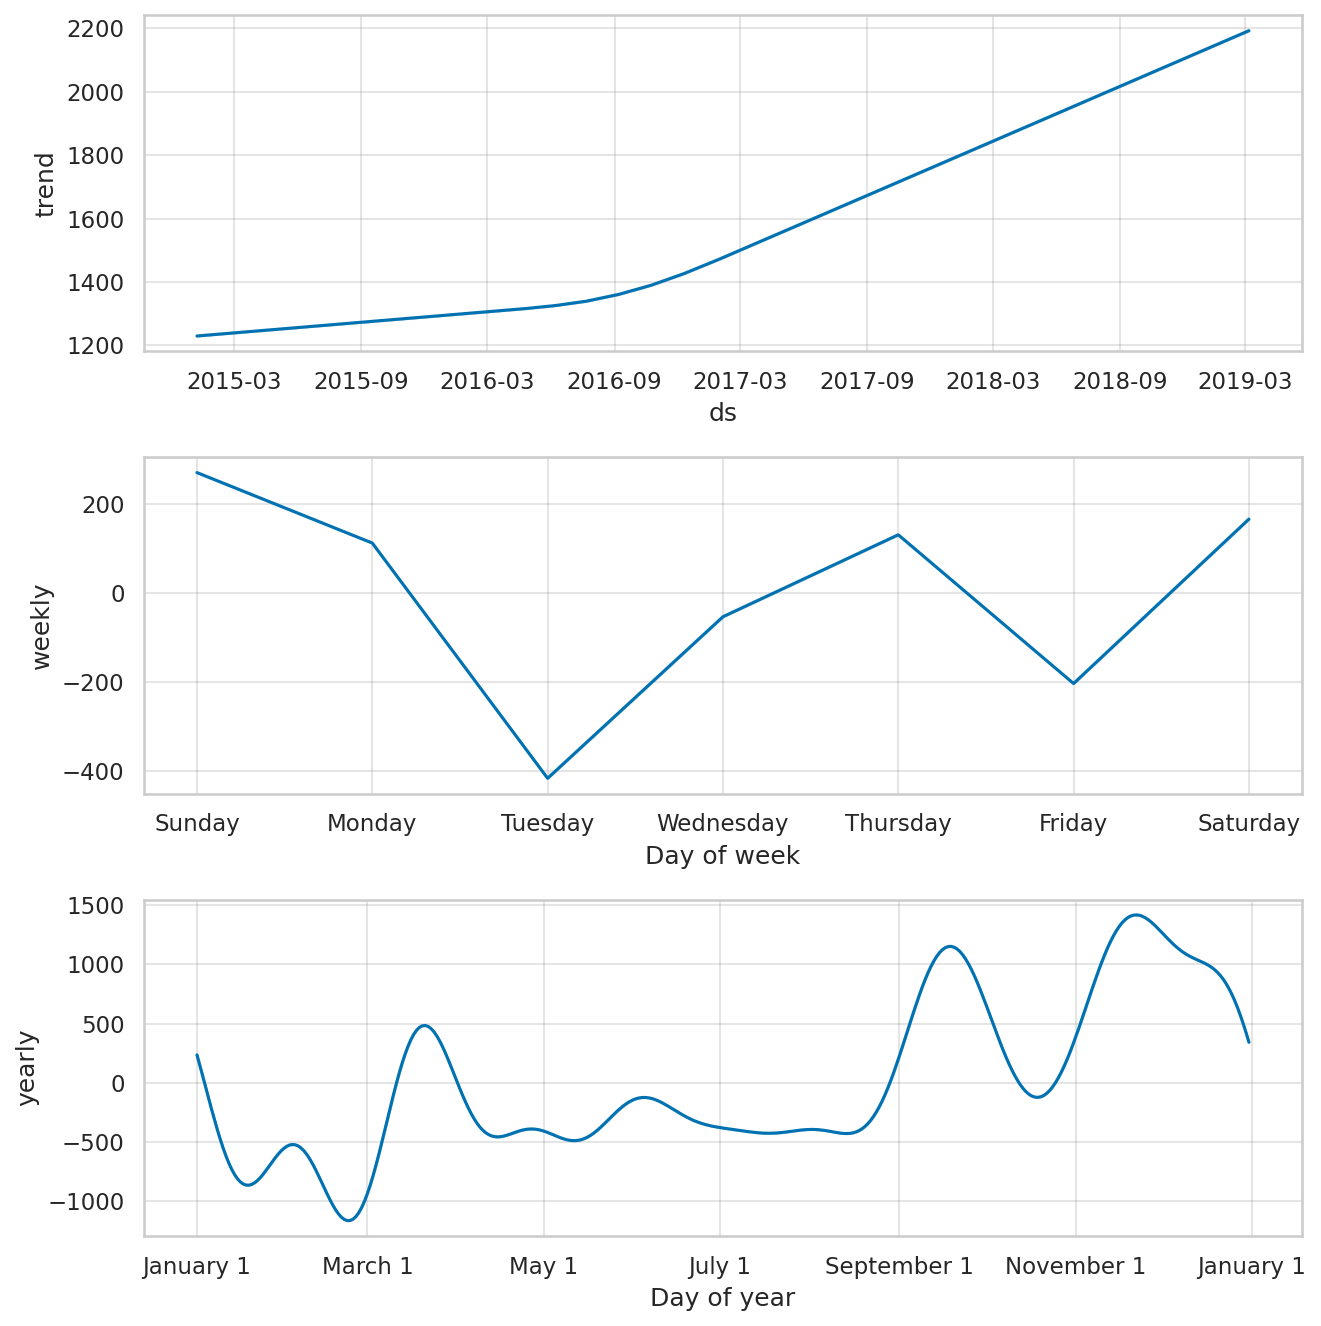

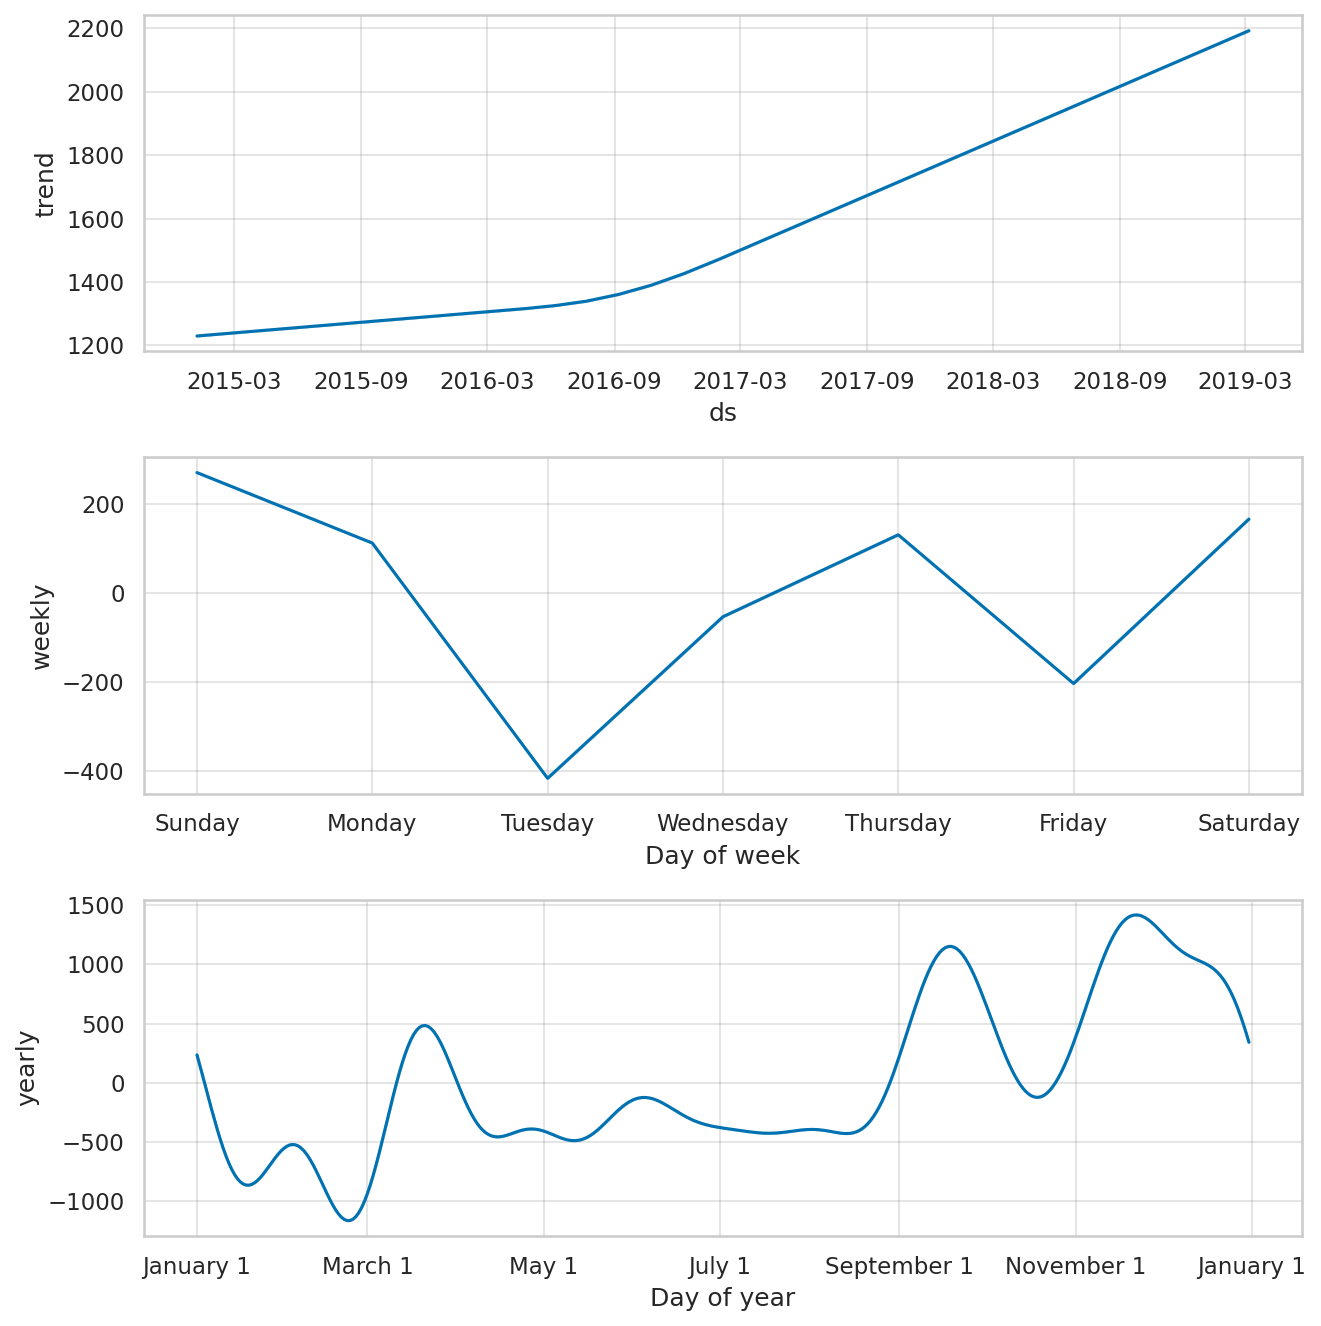

In [ ]:
# plot the components
m.plot_components(forecast)

In [ ]:
# have a look at the first 5 forecasts
forecast.head()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-01-07  1229.81    -1668.78     3241.51      1229.81      1229.81   
1 2015-01-08  1229.99    -1617.80     3505.61      1229.99      1229.99   
2 2015-01-09  1230.17    -1979.21     3270.64      1230.17      1230.17   
3 2015-01-10  1230.35    -1619.99     3389.58      1230.35      1230.35   
4 2015-01-11  1230.54    -1326.34     3596.08      1230.54      1230.54   

   additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0         -319.08               -319.08               -319.08  -54.28   
1         -221.75               -221.75               -221.75  129.85   
2         -638.63               -638.63               -638.63 -204.27   
3         -347.04               -347.04               -347.04  165.01   
4         -314.14               -314.14               -314.14  269.55   

   weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0        -54.28        -54.28 -264.80       -264.80       -264.80   
1        129.85        129.85 -351.60       -351.60       -351.60   
2       -204.27       -204.27 -434.36       -434.36       -434.36   
3        165.01        165.01 -512.05       -512.05       -512.05   
4        269.55        269.55 -583.69       -583.69       -583.69   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper     yhat  
0                         0.0   910.72  
1                         0.0  1008.24  
2                         0.0   591.54  
3                         0.0   883.32  
4                         0.0   916.40

In [ ]:
# have a look at the last 5 forecasts
forecast.tail()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1515 2019-03-02  2188.75     -939.02     4209.81      2187.52      2189.88   
1516 2019-03-03  2189.70     -882.36     4040.68      2188.41      2190.85   
1517 2019-03-04  2190.64     -915.74     4121.26      2189.30      2191.83   
1518 2019-03-05  2191.58    -1326.27     3585.13      2190.21      2192.82   
1519 2019-03-06  2192.52     -784.86     4166.79      2191.11      2193.80   

      additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
1515         -733.66               -733.66               -733.66  165.01   
1516         -551.63               -551.63               -551.63  269.55   
1517         -625.02               -625.02               -625.02  111.27   
1518        -1062.35              -1062.35              -1062.35 -417.12   
1519         -603.70               -603.70               -603.70  -54.28   

      weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
1515        165.01        165.01 -898.67       -898.67       -898.67   
1516        269.55        269.55 -821.18       -821.18       -821.18   
1517        111.27        111.27 -736.28       -736.28       -736.28   
1518       -417.12       -417.12 -645.23       -645.23       -645.23   
1519        -54.28        -54.28 -549.41       -549.41       -549.41   

      multiplicative_terms  multiplicative_terms_lower  \
1515                   0.0                         0.0   
1516                   0.0                         0.0   
1517                   0.0                         0.0   
1518                   0.0                         0.0   
1519                   0.0                         0.0   

      multiplicative_terms_upper     yhat  
1515                         0.0  1455.09  
1516                         0.0  1638.06  
1517                         0.0  1565.62  
1518                         0.0  1129.23  
1519                         0.0  1588.83

In [ ]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the last 5 records
forecast_summary = forecast[['ds','yhat_lower','yhat_upper','yhat']]
forecast_summary.tail()

ds  yhat_lower  yhat_upper     yhat
1515 2019-03-02     -939.02     4209.81  1455.09
1516 2019-03-03     -882.36     4040.68  1638.06
1517 2019-03-04     -915.74     4121.26  1565.62
1518 2019-03-05    -1326.27     3585.13  1129.23
1519 2019-03-06     -784.86     4166.79  1588.83

In [ ]:
# create a new dataframe the forecast period
start_date = '2019-01-06'
end_date = '2019-03-06'
mask = (forecast_summary.ds >= start_date) & (forecast_summary.ds <= end_date)
forecast_sales = forecast_summary.loc[mask]
print(forecast_sales.head())
print(forecast_sales.tail())

             ds  yhat_lower  yhat_upper     yhat
1460 2019-01-06     -241.58     4877.25  2231.38
1461 2019-01-07     -446.09     4715.30  1984.31
1462 2019-01-08    -1182.37     3902.54  1370.07
1463 2019-01-09     -691.73     4258.30  1651.08
1464 2019-01-10     -753.84     4251.39  1758.47
             ds  yhat_lower  yhat_upper     yhat
1515 2019-03-02     -939.02     4209.81  1455.09
1516 2019-03-03     -882.36     4040.68  1638.06
1517 2019-03-04     -915.74     4121.26  1565.62
1518 2019-03-05    -1326.27     3585.13  1129.23
1519 2019-03-06     -784.86     4166.79  1588.83


In [ ]:
# what's the forecast sales for the 60 days forecast horizon
forecast_60_sales = forecast_sales['yhat'].sum()
forecast_60_upper = forecast_sales['yhat_upper'].sum()
forecast_60_lower = forecast_sales['yhat_lower'].sum()
print(f"The forecasted sales amount for the period 2019-01-06 to 2019-03-06: {forecast_60_sales:,.0f}")
print(f"with the upper bound of forecasted sales amount for the period 2019-01-06 to 2019-03-06 at: {forecast_60_upper:,.0f}")

The forecasted sales amount for the period 2019-01-06 to 2019-03-06: 83,879
with the upper bound of forecasted sales amount for the period 2019-01-06 to 2019-03-06 at: 236,678


In [ ]:
# cross validation
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='60 days')
df_cv.head()

INFO:prophet:Making 4 forecasts with cutoffs between 2017-05-15 00:00:00 and 2018-11-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/n_cqui8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/of0942u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62649', 'data', 'file=/tmp/tmp8phfgpux/n_cqui8e.json', 'init=/tmp/tmp8phfgpux/of0942u2.json', 'output', 'file=/tmp/tmp8phfgpux/prophet_modela8gehme7/prophet_model-20231020044406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/m13mjek4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/mmnl3lkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

ds     yhat  yhat_lower  yhat_upper        y     cutoff
0 2017-05-16   285.81    -1991.80     2490.16   151.59 2017-05-15
1 2017-05-17   503.56    -1661.14     2735.68   779.25 2017-05-15
2 2017-05-18   851.45    -1371.49     3108.59   253.03 2017-05-15
3 2017-05-19   716.67    -1470.42     3001.81   524.57 2017-05-15
4 2017-05-20  1192.95    -1078.14     3372.04  2040.02 2017-05-15

In [ ]:
# performance metrics
from prophet.diagnostics import performance_metrics

pm = performance_metrics(df_cv)
pm.tail()

INFO:prophet:Skipping MAPE because y close to 0


horizon       mse     rmse      mae  mdape  smape  coverage
50 56 days  3.06e+06  1750.68  1196.67   0.42   0.69      0.88
51 57 days  2.50e+06  1580.38  1039.80   0.34   0.57      0.92
52 58 days  2.70e+06  1644.64  1137.79   0.54   0.71      0.92
53 59 days  2.66e+06  1629.99  1127.99   0.61   0.72      0.92
54 60 days  1.52e+06  1233.80   967.06   0.61   0.71      1.00

In [ ]:
# average rmse for the model without reduced outliers
pm.rmse.mean()

2153.3724565790785

In [ ]:
# average smape for the model without reduced outliers
pm.smape.mean()

0.7476362404797121

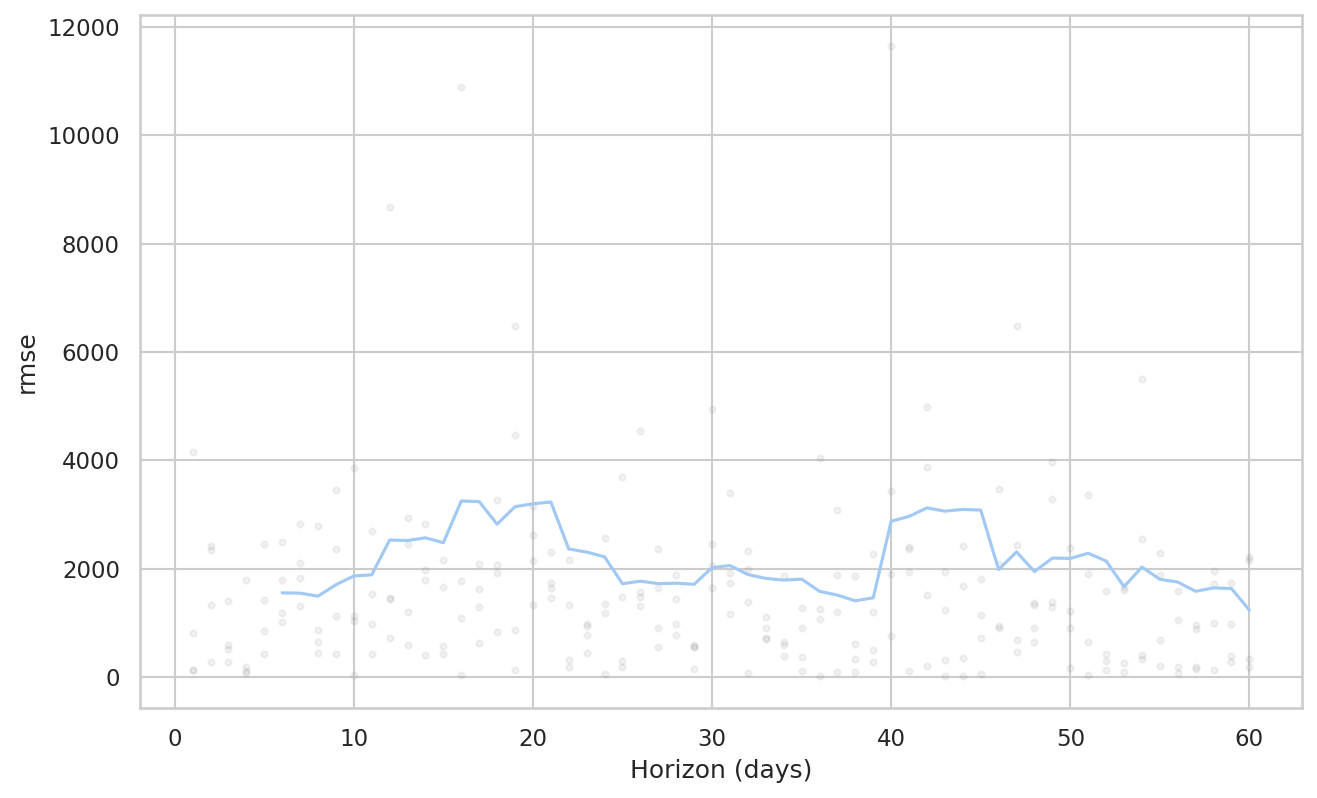

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

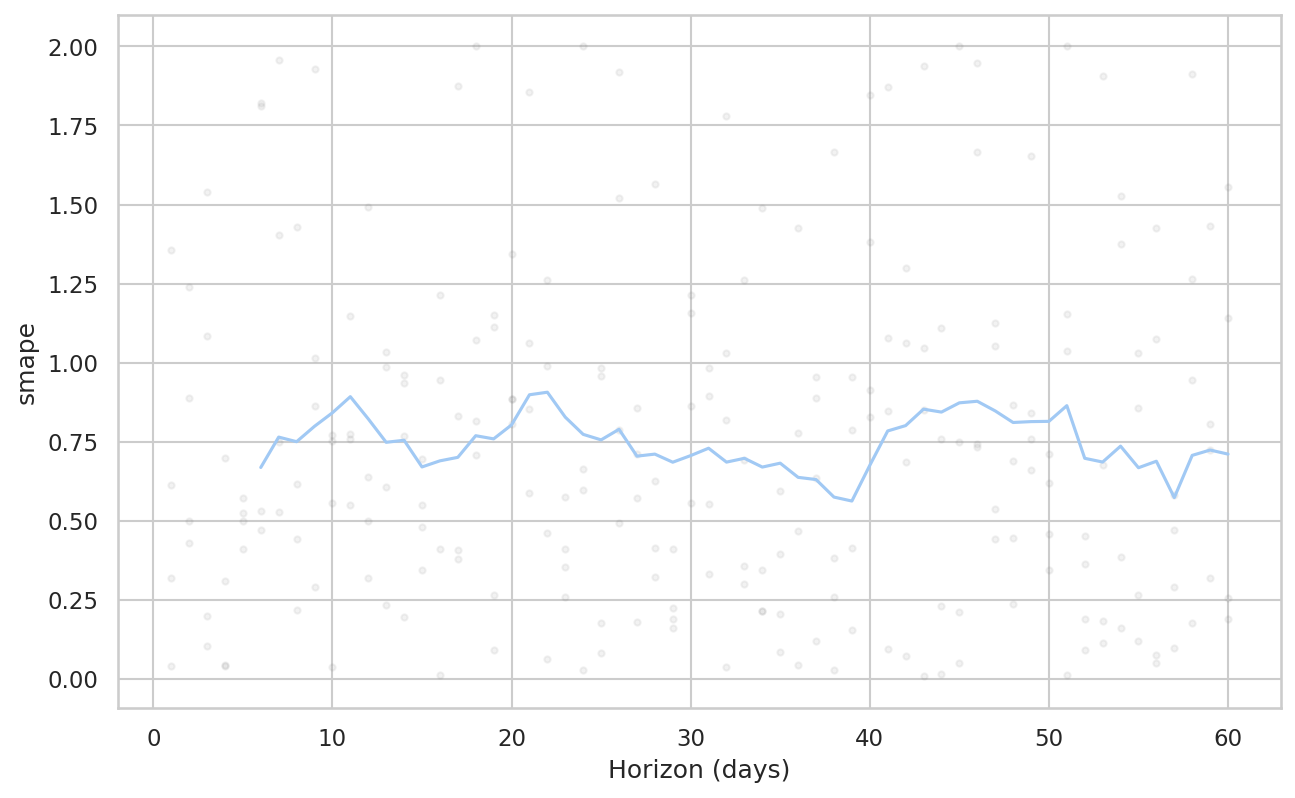

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='smape')

In [ ]:
# another way of visualizing the predictions
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:
# comparison of errors
results = pd.concat([df1.set_index('ds')['y'], forecast_summary.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']
results.head()


y     yhat  yhat_lower  yhat_upper    error  uncertainty
ds                                                                        
2015-01-07    29.23   910.72    -1668.78     3241.51  -881.50      4910.30
2015-01-08   307.50  1008.24    -1617.80     3505.61  -700.74      5123.42
2015-01-09     0.00   591.54    -1979.21     3270.64  -591.54      5249.85
2015-01-10  4374.88   883.32    -1619.99     3389.58  3491.56      5009.57
2015-01-11     0.00   916.40    -1326.34     3596.08  -916.40      4922.42

In [ ]:
# have a look at the last 5 records
results.tail()

y     yhat  yhat_lower  yhat_upper  error  uncertainty
ds                                                                 
2019-03-02 NaN  1455.09     -939.02     4209.81    NaN      5148.84
2019-03-03 NaN  1638.06     -882.36     4040.68    NaN      4923.04
2019-03-04 NaN  1565.62     -915.74     4121.26    NaN      5036.99
2019-03-05 NaN  1129.23    -1326.27     3585.13    NaN      4911.40
2019-03-06 NaN  1588.83     -784.86     4166.79    NaN      4951.64

# Experimenting with the same dataset with outliers removed

In [ ]:
# make a copy of the "normal" dataset
df2 = df_normal[['Ship Date','Sales']]
df2.head()

Ship Date   Sales
0 2017-11-11  261.96
1 2017-11-11  731.94
2 2017-06-16   14.62
3 2016-10-18  957.58
4 2016-10-18   22.37

In [ ]:
# group sales by day
df2 = df2.resample('D', on='Ship Date').sum().reset_index()
df2.sample(5)

Ship Date    Sales
1247 2018-06-07   262.39
81   2015-03-29    40.48
1178 2018-03-30  2938.49
124  2015-05-11   113.72
1210 2018-05-01   313.01

In [ ]:
# rename columns to ds (datetime object) and y (target) as per FB convention
df2.columns = ['ds','y']
df2.tail()

ds        y
1455 2019-01-01  2390.15
1456 2019-01-02  1545.62
1457 2019-01-03   569.27
1458 2019-01-04   344.22
1459 2019-01-05   310.42

In [ ]:
# set up the model
m1 = Prophet()

In [ ]:
# train the model
m1.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/fqify9zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/i4ga6kai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38946', 'data', 'file=/tmp/tmp8phfgpux/fqify9zv.json', 'init=/tmp/tmp8phfgpux/i4ga6kai.json', 'output', 'file=/tmp/tmp8phfgpux/prophet_modelvlz3y2xd/prophet_model-20231020044410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# create a future DF for the forecast horizon
forecast_horizon = 60
future1 = m1.make_future_dataframe(periods=forecast_horizon, freq='D')

In [ ]:
# make the predictions
forecast1 = m1.predict(future1)

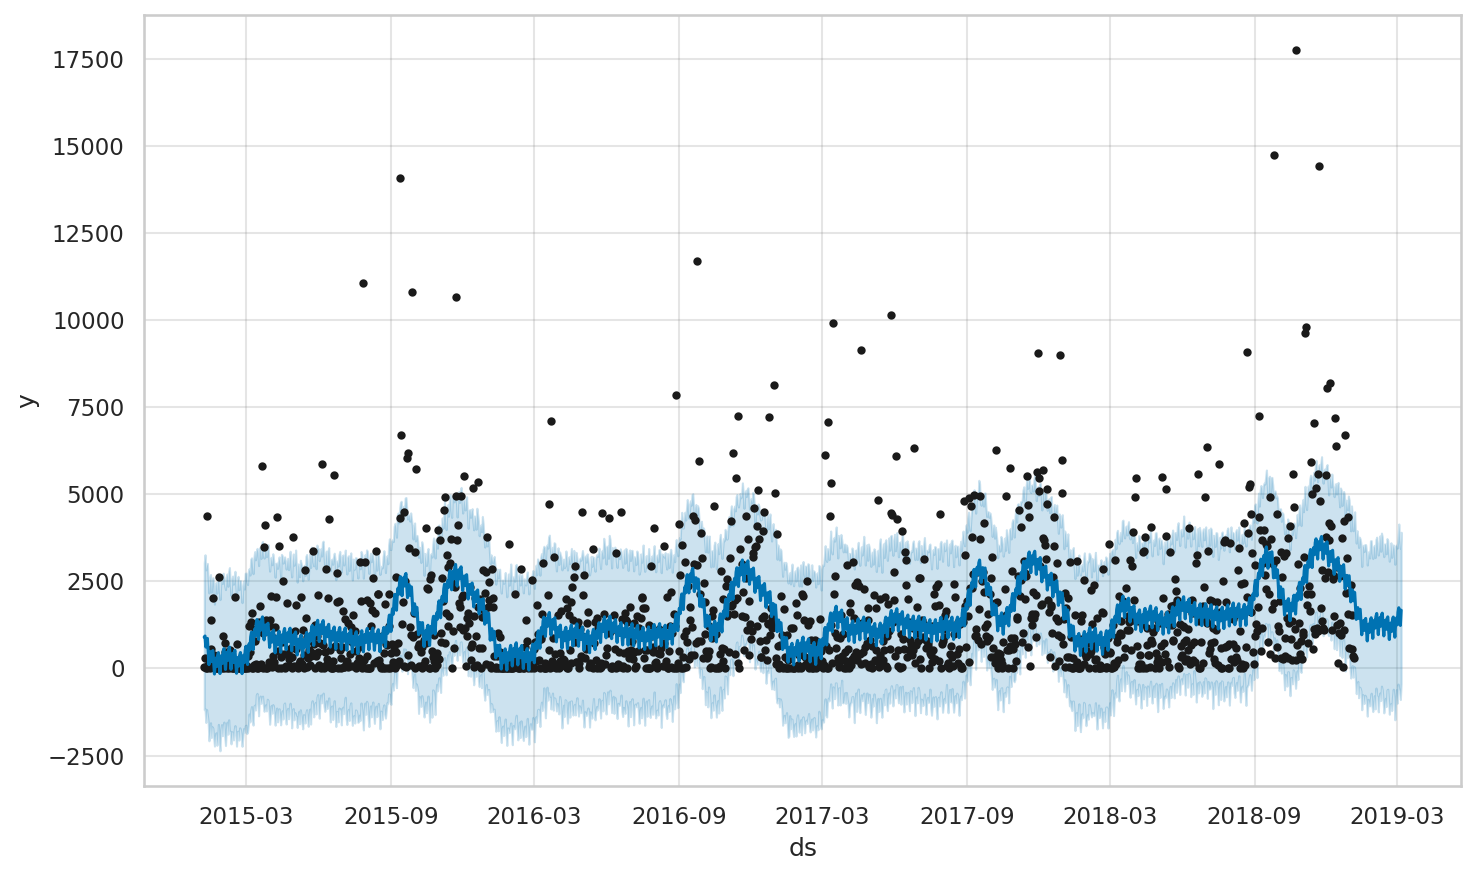

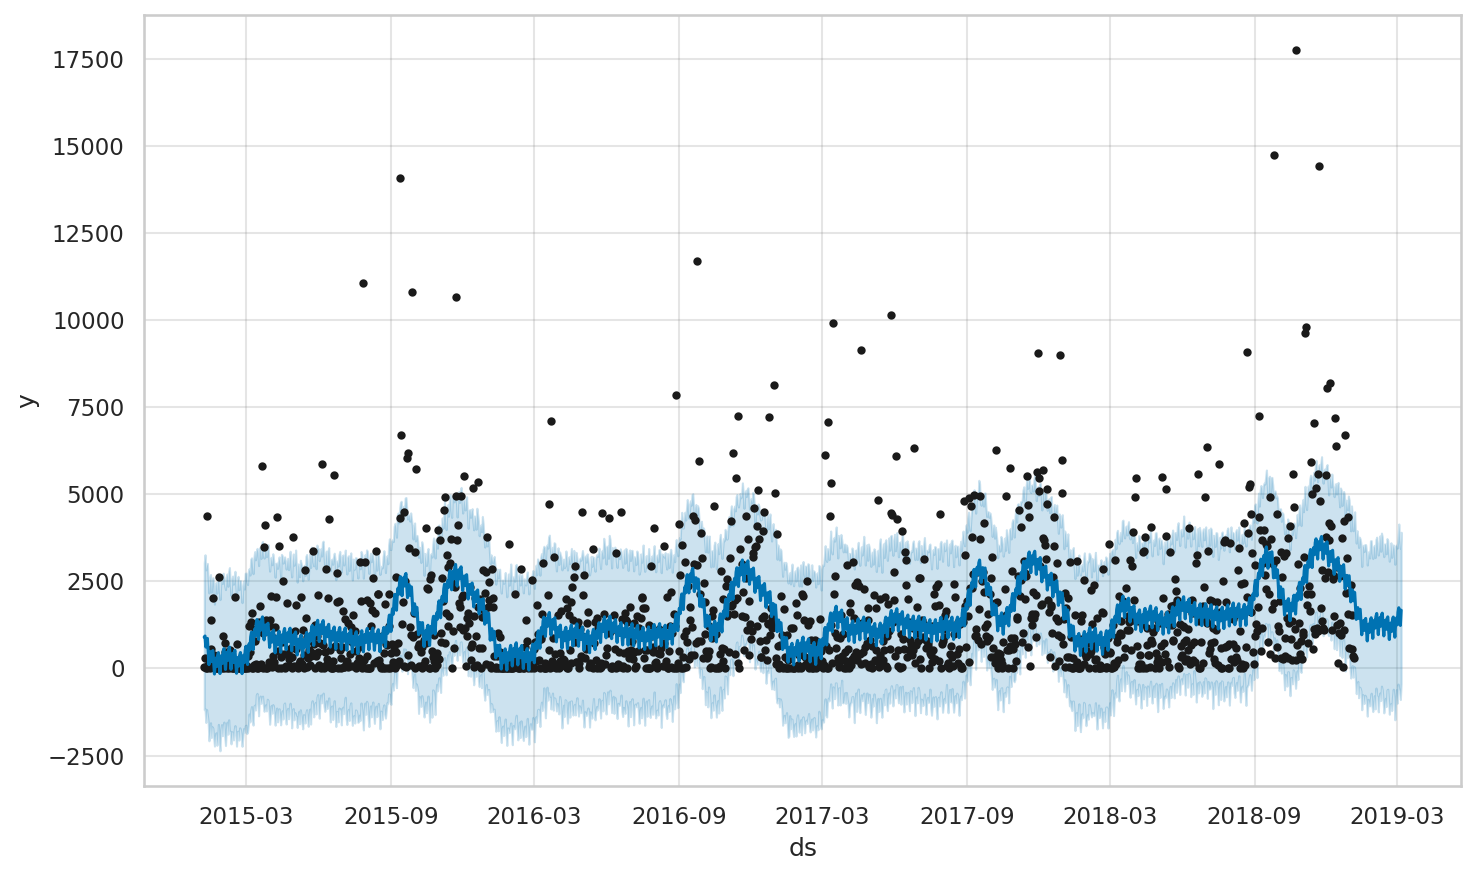

In [ ]:
# plotting the predictions
m1.plot(forecast1)

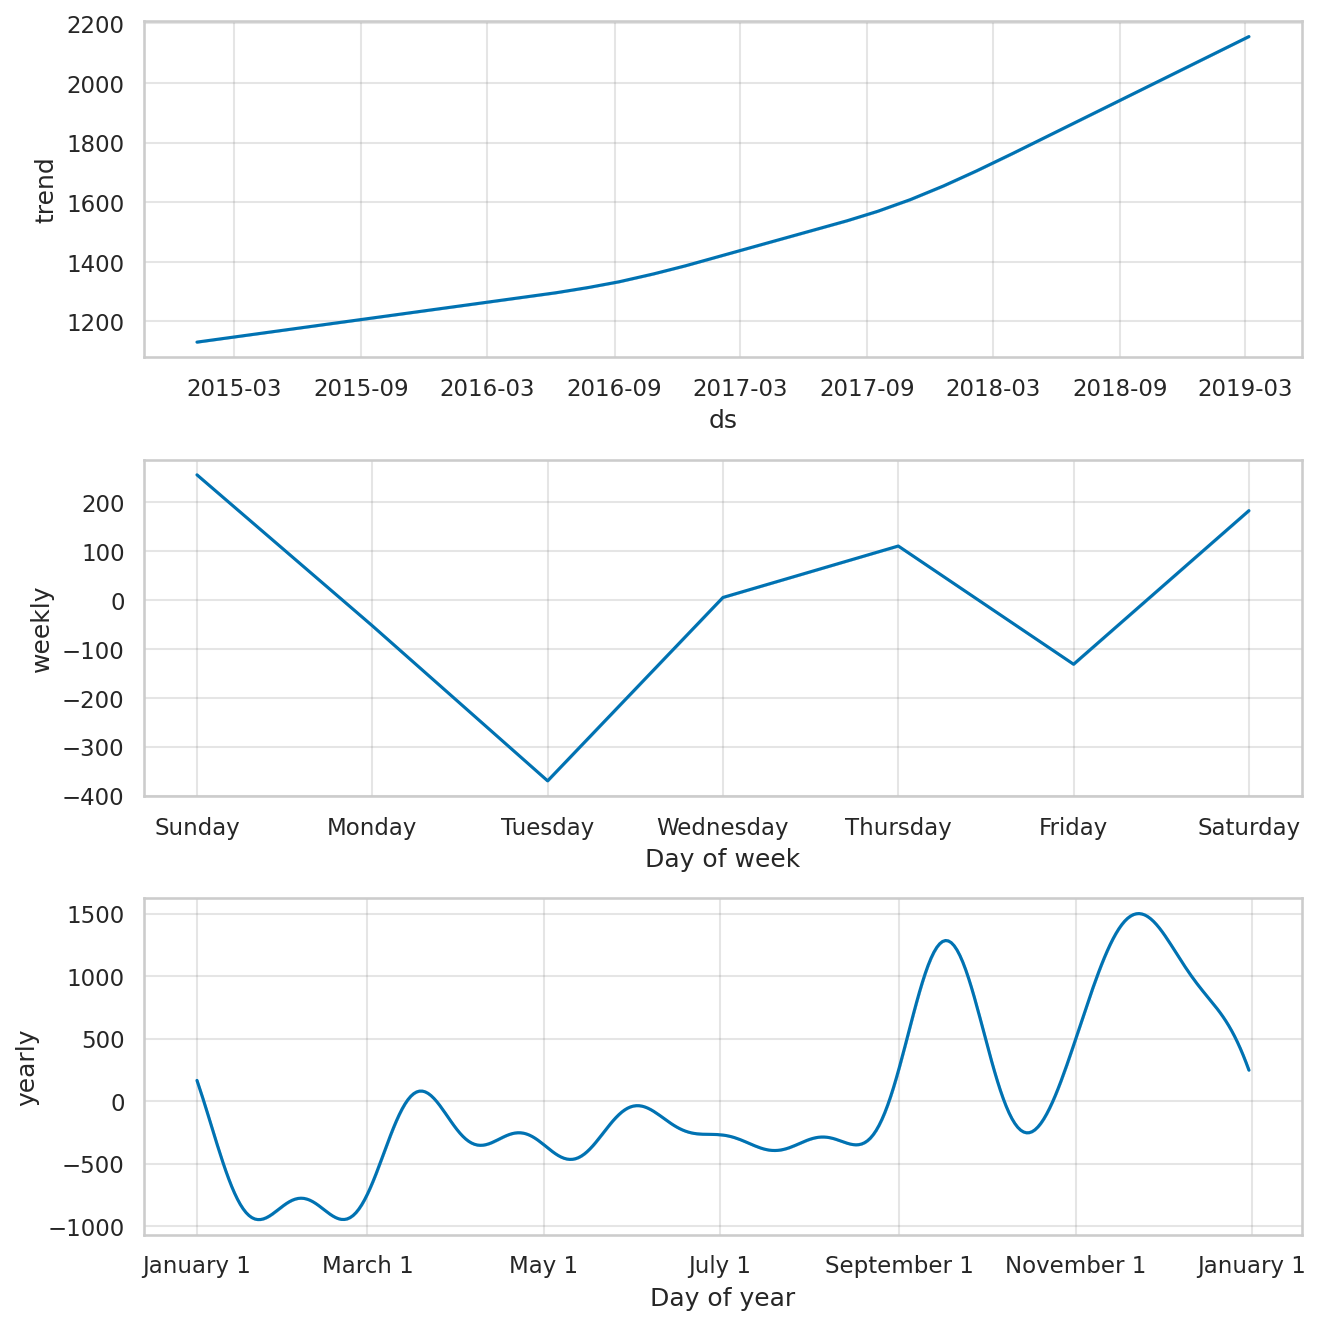

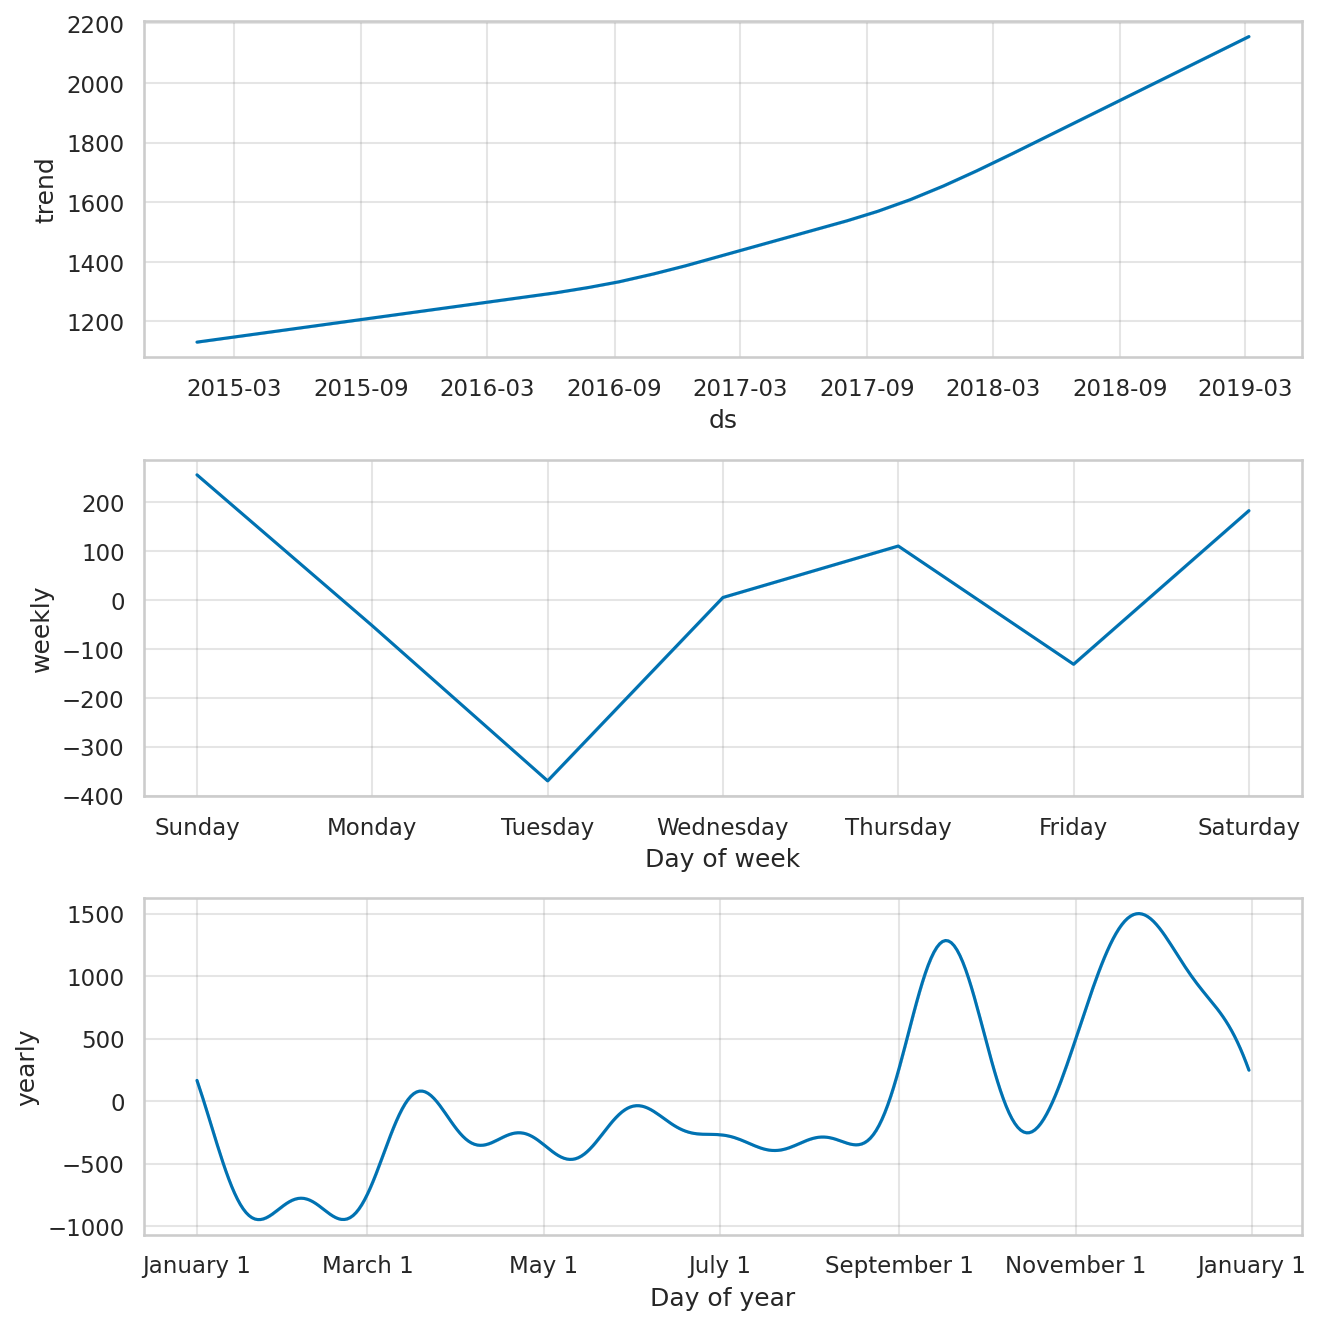

In [ ]:
# plot the components
m1.plot_components(forecast1)

In [ ]:
# create a new DF to store relevant information about the predictions (yhat = prediction, yhat_lower and yhat_upper are the lower and upper bound / confidence levels of the predictions) & have a look at the last 5 records
forecast_summary1 = forecast1[['ds','yhat_lower','yhat_upper','yhat']]
forecast_summary1.tail()

ds  yhat_lower  yhat_upper     yhat
1515 2019-03-02     -449.26     3741.02  1614.40
1516 2019-03-03     -584.54     4147.43  1741.51
1517 2019-03-04     -639.82     3703.34  1490.51
1518 2019-03-05     -894.14     3449.69  1233.90
1519 2019-03-06     -439.23     3909.83  1671.44

In [ ]:
# create a new dataframe the forecast period
start_date = '2019-01-06'
end_date = '2019-03-06'
mask1 = (forecast_summary1.ds >= start_date) & (forecast_summary1.ds <= end_date)
forecast_sales1 = forecast_summary1.loc[mask1]
print(forecast_sales1.head())
print(forecast_sales1.tail())

             ds  yhat_lower  yhat_upper     yhat
1460 2019-01-06        6.52     4497.93  2182.29
1461 2019-01-07     -346.84     3917.73  1799.24
1462 2019-01-08     -724.30     3597.24  1408.12
1463 2019-01-09     -443.24     3955.55  1710.36
1464 2019-01-10     -371.37     3782.02  1744.86
             ds  yhat_lower  yhat_upper     yhat
1515 2019-03-02     -449.26     3741.02  1614.40
1516 2019-03-03     -584.54     4147.43  1741.51
1517 2019-03-04     -639.82     3703.34  1490.51
1518 2019-03-05     -894.14     3449.69  1233.90
1519 2019-03-06     -439.23     3909.83  1671.44


In [ ]:
# what's the forecast sales for the 60 days forecast horizon
forecast_60_sales1 = forecast_sales1['yhat'].sum()
forecast_60_upper1 = forecast_sales1['yhat_upper'].sum()
forecast_60_lower1 = forecast_sales1['yhat_lower'].sum()
print(f"The forecasted sales amount (adjusted for outliers) for the period {start_date} to {end_date}: {forecast_60_sales1:,.0f}")
print(f"with the upper bound of forecasted sales amount (adjusted for outliers) for the period 2019-01-06 to 2019-03-06 at: {forecast_60_upper1:,.0f}")

The forecasted sales amount (adjusted for outliers) for the period 2019-01-06 to 2019-03-06: 80,156
with the upper bound of forecasted sales amount (adjusted for outliers) for the period 2019-01-06 to 2019-03-06 at: 211,093


In [ ]:
# cross validation
from prophet.diagnostics import cross_validation
df_cv1 = cross_validation(m1, initial='730 days', period='180 days', horizon='60 days')
df_cv1.head()

INFO:prophet:Making 4 forecasts with cutoffs between 2017-05-15 00:00:00 and 2018-11-06 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/4jeg5072.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/x0wz_1lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26556', 'data', 'file=/tmp/tmp8phfgpux/4jeg5072.json', 'init=/tmp/tmp8phfgpux/x0wz_1lw.json', 'output', 'file=/tmp/tmp8phfgpux/prophet_model5_46c2oc/prophet_model-20231020044417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/gbpfvw51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8phfgpux/3103q0tu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

ds     yhat  yhat_lower  yhat_upper        y     cutoff
0 2017-05-16   412.26    -1369.04     2357.06   151.59 2017-05-15
1 2017-05-17   635.49    -1244.96     2661.81   779.25 2017-05-15
2 2017-05-18   987.86     -946.50     2699.64   253.03 2017-05-15
3 2017-05-19   856.59    -1073.00     2766.49   524.57 2017-05-15
4 2017-05-20  1264.30     -538.25     3131.63  2040.02 2017-05-15

In [ ]:
# performance metrics
from prophet.diagnostics import performance_metrics

pm1 = performance_metrics(df_cv1)
pm1.tail()

INFO:prophet:Skipping MAPE because y close to 0


horizon       mse     rmse      mae  mdape  smape  coverage
50 56 days  2.94e+06  1714.73  1141.14   0.46   0.66      0.83
51 57 days  2.40e+06  1550.66   981.79   0.31   0.54      0.88
52 58 days  2.53e+06  1592.16  1064.13   0.55   0.67      0.88
53 59 days  2.53e+06  1589.13  1080.70   0.58   0.71      0.88
54 60 days  1.42e+06  1191.29   936.65   0.58   0.70      0.88

In [ ]:
# average rmse for the model with reduced outliers
pm1.rmse.mean()

2007.3546677840782

In [ ]:
# average smape for the model with reduced outliers
pm1.smape.mean()

0.7359543621860521

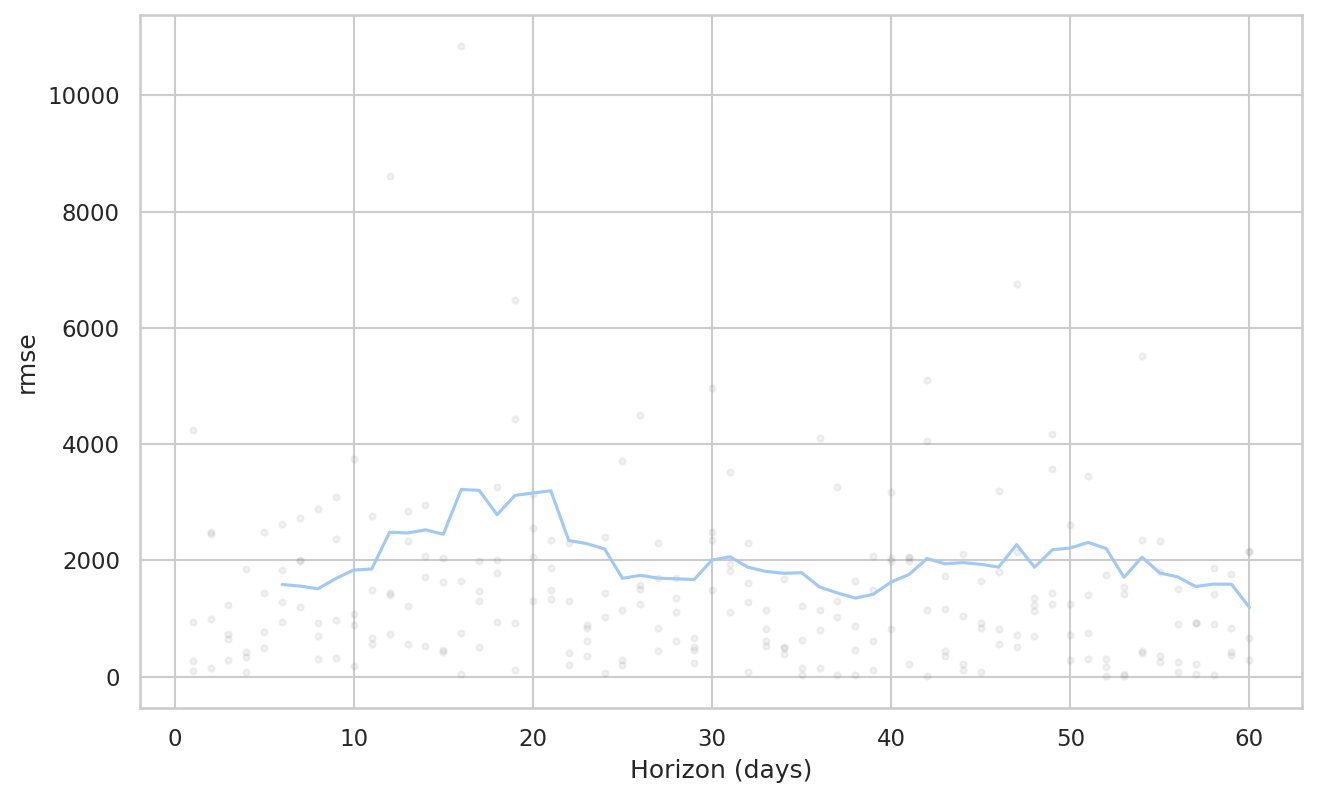

In [ ]:
fig1 = plot_cross_validation_metric(df_cv1, metric='rmse')

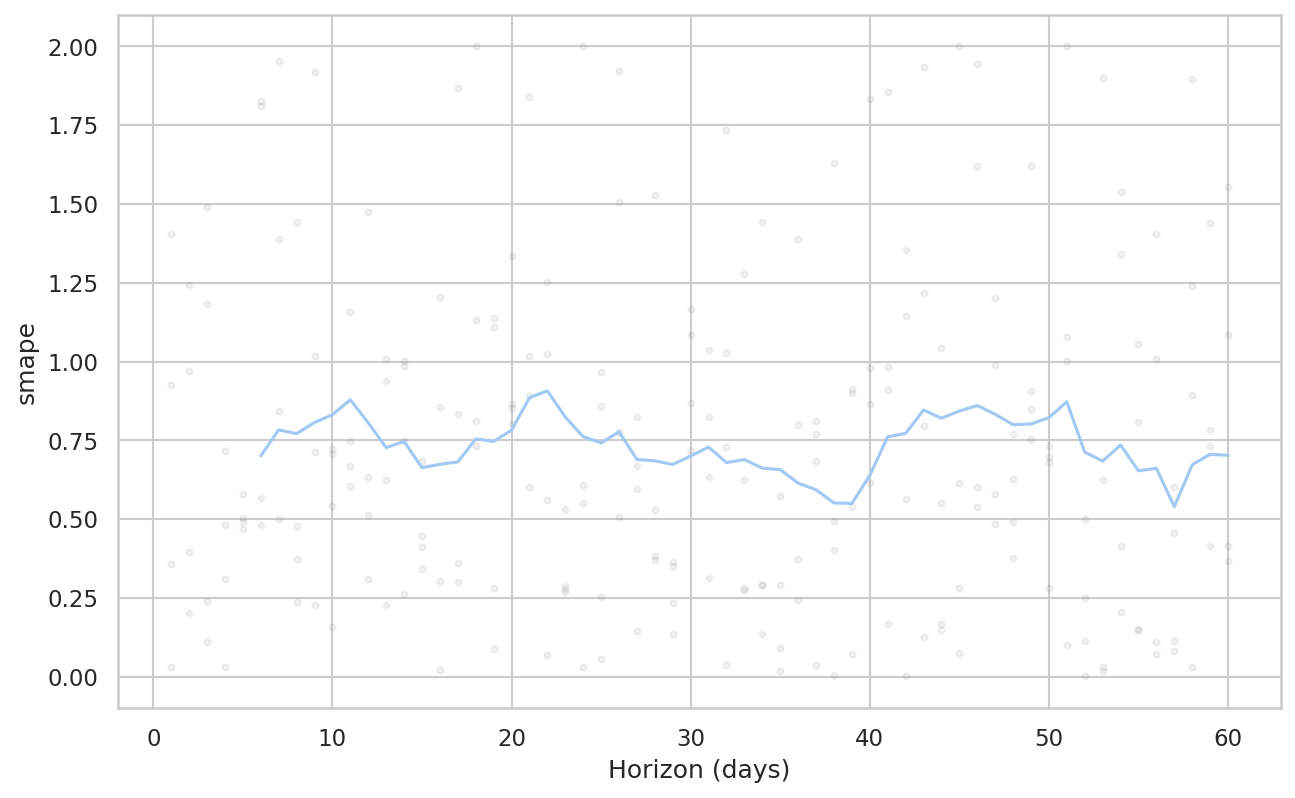

In [ ]:
fig2 = plot_cross_validation_metric(df_cv1, metric='smape')


In [ ]:
# comparison of errors
results1 = pd.concat([df2.set_index('ds')['y'], forecast_summary1.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
results1['error'] = results1['y'] - results1['yhat']
results1['uncertainty'] = results1['yhat_upper'] - results1['yhat_lower']
results1.head()

y    yhat  yhat_lower  yhat_upper    error  uncertainty
ds                                                                       
2015-01-07    29.23  899.27    -1185.07     3024.17  -870.05      4209.24
2015-01-08   307.50  929.70    -1150.85     3263.98  -622.20      4414.82
2015-01-09     0.00  614.33    -1552.43     2829.38  -614.33      4381.81
2015-01-10  4374.88  856.88    -1181.85     2967.59  3518.00      4149.44
2015-01-11     0.00  861.32    -1341.50     3016.73  -861.32      4358.24

From the results above (based on rmse as well as smape) the model with outliers removed achieved a better/lower overall rmse and smape scores.

# Supplementary Information

In [ ]:
# knowing the setup of the model
m.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
# understanding the parameters
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'calculate_initial_params',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot